## Conceitos Iniciais

A volatilidade é uma medida de variação dos retornos de um ativo. É um fator crucial a ser considerado na tomada de decisão de investimentos. Investidores que têm maior tolerância ao risco podem buscar ativos com maior volatilidade, esperando por maiores retornos. Por outro lado, investidores com perfil mais conservador podem preferir ativos com menor volatilidade, visando preservar o capital.

In [1]:
import pandas as pd
import numpy as np
import turingquant as tq
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
df = yf.download(["ITUB3.SA"], start='2007-01-01')
returns = tq.metrics.returns(df["Close"])

[*********************100%***********************]  1 of 1 completed


O retorno de um ativo é a mudança percentual de seu preço, baseado em dois momentos diferentes no tempo.

$$R_i = \frac{P_{i+1} - P_{i}}{P_{i}} $$

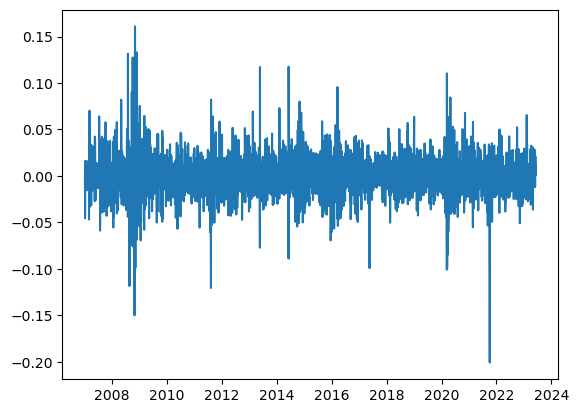

In [3]:
plt.plot(returns)

Vamos falar sobre quatro formar de estimar a volatilidade de um ativo financeiro.

## Rolling std

Essa é a forma mais simples de estimar a volatilidade de um ativo, sendo simplesmente o desvio padrão dos retornos dentro da janela selecionada. Todas observações tem o mesmo peso e só se usa o preço de fechamento.

<AxesSubplot:xlabel='Date'>

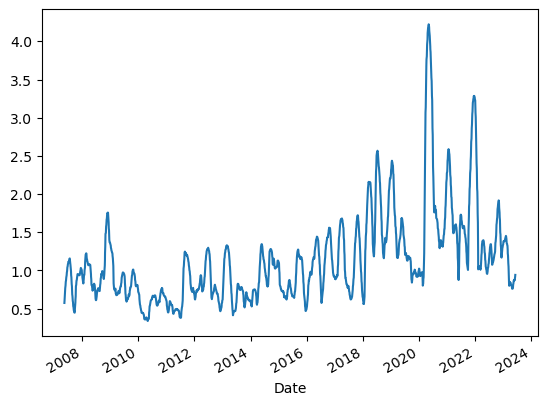

In [4]:
df['Close'].rolling(90).std().plot() # volatilidade baseada em uma janela de 90 dias.

## EWMA

A volatilidade EWMA (Exponential Weighted Moving Average) é uma abordagem comumente utilizada para estimar a volatilidade em séries temporais financeiras. Ao contrário de outras medidas de volatilidade, como o desvio padrão simples, a volatilidade EWMA dá mais peso aos dados mais recentes, atribuindo-lhes um maior impacto na estimativa da volatilidade. Mas usa somente o preço de fechamento.

In [5]:
def plot_ewma_volatility(returns, window):
    """
    Essa função possibilita a visualização da volatilidade a partir do cálculo da EWMA e da plotagem do gráfico 
    dessa métrica ao longo de um período.

    Args:
        returns (pd.Series): série de retornos para o qual o EWMA será calculado.
        window (int): janela móvel para cálculo da EWMA;

    Returns:
        pd.Series: uma série com os valores de EWMA dos últimos `window` dias
    """

    ewma_volatility_series = tq.metrics.ewma_volatility(returns, window)
    fig = px.line(ewma_volatility_series, x=ewma_volatility_series.index,
                    y='Close', title='EWMA')
    fig.update_xaxes(title_text='Tempo')
    fig.update_yaxes(title_text='EWMA')
    fig.show()

    return ewma_volatility_series

In [13]:
fig = px.line(returns, x=returns.index,
                y='Close', title='EWMA - Retornos')
fig.update_xaxes(title_text='Tempo')
fig.update_yaxes(title_text='EWMA')
fig.show()

In [7]:
#tq.metrics.ewma_volatility(returns, window=20)
import plotly.express as px
plot_ewma_volatility(returns, 20)

Date
2007-01-02         NaN
2007-01-03         NaN
2007-01-04    0.000000
2007-01-05    0.026880
2007-01-08    0.027364
                ...   
2023-06-02    0.012576
2023-06-05    0.012226
2023-06-06    0.011630
2023-06-07    0.011080
2023-06-09    0.011844
Name: Close, Length: 4076, dtype: float64

## Parkinson

Aqui temos a primeira medida de volatilidade que não usa só o preço de fechamento, mas usa os preços máximos e mínimos diários para aumentar a precisão da medição.

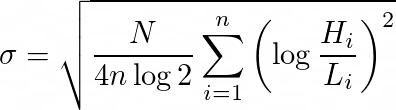

In [8]:
def parkinson_volatility(high_prices, low_prices, window, time_scale=1, plot=False):
    """
    Estimando a volatilidade a partir dos preços de Alta e de Baixa

    Args:
        high (pd.DataFrame): série de preços de alta de uma ação
        low (pd.DataFrame): série de preços de baixa de uma ação
        window (int): janela das estimativa de volatilidade
        time_scale (int): fator de escala da volatilidade, por padrão é 1 (diária)

    Returns: 
        pd.Series: série das estimativas de volatildade

    """

    log_ratio = np.log(np.divide(high_prices, low_prices)) ** 2

    parkinson_vol = pd.Series(log_ratio, name='Parkinson', copy=True)

    Period_const = time_scale / (4 * window * np.log(2))

    parkinson_vol.iloc[:window] = np.nan

    for date in range(window, len(high_prices)):
        parkinson_vol.iloc[date] = np.sqrt(
            Period_const * np.sum(log_ratio.iloc[date - window: date])
        )

    return parkinson_vol

<AxesSubplot:xlabel='Date'>

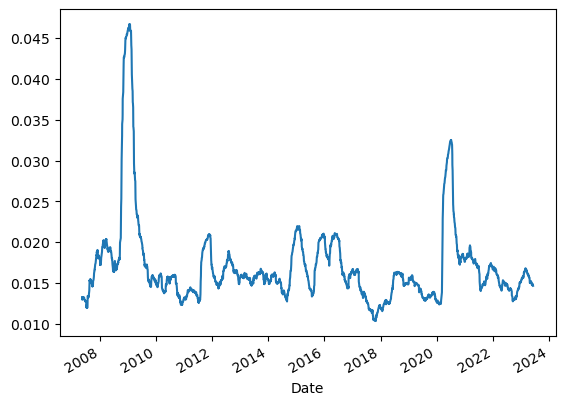

In [9]:
parkinson_volatility(df['High'],df['Low'],90).plot()

## Garman Klass

É, provavelmente, a função de cálculo de volatilidade mais completa das 3 estudadas (EWMA, Parkinson e Garman Klass), pois leva em consideração a série de preços de alta e de baixa da ação, os preços de abertura e fechamento da ação e ainda um fator de escala de volatilidade. Com isso, temos a seguinte fórmula:

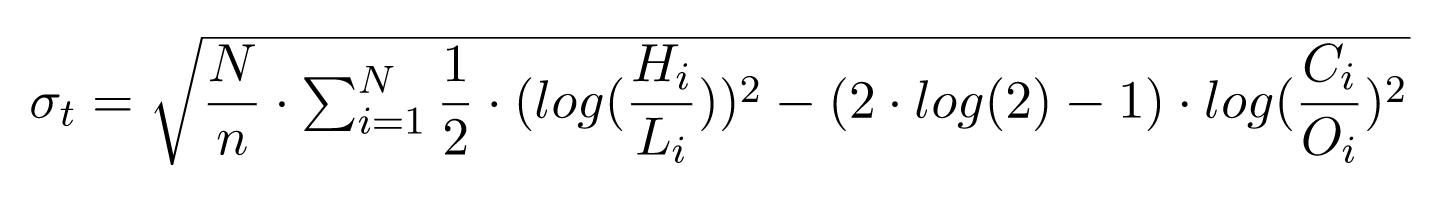

**Onde:**
1. (N/n) é o fator de escala da volatilidade
2. O somatório é a estimativa da variância da função

In [10]:
def garman_klass_volatility(df, window=20, time_scale=1):
    """
    Estima a volatilidade a partir dos seguintes preços: alta, baixa, abertura e fechamento
    Args:
        high_prices (pd.DataFrame): série de preços de alta de uma ação
        low_prices (pd.DataFrame): série de preços de baixa de uma ação
        close_prices (pd.DataFrame): série de preços de fechamento de uma ação
        open_prices (pd.DataFrame): série de preços de abertura de uma ação
        window (int): janela das estimativa de volatilidade
        time_scale (int): fator de escala da volatilidade, por padrão é 1 (diária)
    Returns: 
        pd.Series: série das estimativas de volatildade
    """
    open_prices = df["Open"]
    high_prices = df["High"]
    low_prices = df['Low']
    close_prices = df['Close']
    
    high_low_ratio = (1 / 2) * \
        (np.log(np.divide(high_prices, low_prices))) ** 2

    close_open_ratio = -(2 * np.log(2) - 1) * (
        np.log(np.divide(close_prices, open_prices)) ** 2
    )
        

    log_ratio = high_low_ratio + close_open_ratio.values

    garman_klass_vol = pd.Series(log_ratio, name='Garman Klass', copy=True)

    Period_const = time_scale / window

    garman_klass_vol.iloc[:window] = np.nan

    for date in range(window, len(high_prices)):
        garman_klass_vol.iloc[date] = np.sqrt(
            Period_const * np.sum(log_ratio.iloc[date - window: date])
        )

    return garman_klass_vol

In [11]:
def plot_garman_klass_volatility(df, window=20, time_scale=1):
    """
    Plota a volatilidade a partir dos seguintes preços: alta, baixa, abertura e fechamento
    Args:
        high_prices (pd.DataFrame): série de preços de alta de uma ação
        low_prices (pd.DataFrame): série de preços de baixa de uma ação
        close_prices (pd.DataFrame): série de preços de fechamento de uma ação
        open_prices (pd.DataFrame): série de preços de abertura de uma ação
        window (int): janela das estimativa de volatilidade
        time_scale (int): fator de escala da volatilidade, por padrão é 1 (diária)
    Returns: 
        pd.Series: série das estimativas de volatildade
    """

    garman_klass_vol = garman_klass_volatility(df, window=20, time_scale=1)

    fig = px.line(garman_klass_vol, title='Garman Klass')
    fig.update_xaxes(title_text='Tempo')
    fig.update_yaxes(title_text='Volatilidade')

    mean_garman_klass = garman_klass_vol.mean()
    fig.update_layout(shapes=[
        dict(
            type='line',
            xref='paper', x0=0, x1=1,
            yref='y', y0=mean_garman_klass, y1=mean_garman_klass,
            line=dict(
                color='grey',
                width=2,
                dash='dash'
            )
        )
    ], annotations=[
        dict(
            text='Volatilidade média: %.3f' % mean_garman_klass,
            xref='paper', x=0.95,
            yref='y', y=1.1 * mean_garman_klass,
            xanchor='left'
        )
    ])

    fig.show()

    return garman_klass_vol

In [12]:
plot_garman_klass_volatility(df, window=10, time_scale=1)

C:\Users\danie\AppData\Local\Temp\ipykernel_17792\3942307926.py:36: RuntimeWarning:

invalid value encountered in sqrt



Date
2007-01-02         NaN
2007-01-03         NaN
2007-01-04         NaN
2007-01-05         NaN
2007-01-08         NaN
                ...   
2023-06-02    0.014175
2023-06-05    0.013902
2023-06-06    0.013621
2023-06-07    0.013161
2023-06-09    0.012781
Name: Garman Klass, Length: 4076, dtype: float64

**Observações Interessantes:**
1. Assim como a volatilidade EWMA, a Garman Klass também apresenta dois picos, estes ainda mais nítidos que os da volatilidade EWMA: um do final de 2008 e outro de abril de 2020. Nesse sentido, notam-se picos de volatilidade da ação quando há grandes incertezas econômicas mundiais: a crise de 2008 e a pandemia do novo coronavírus.
2. Novamente em consonância com a EWMA, a Garman Klass apresenta quase todos os valores de volatilidade concentrados entre 0.01 e 0.03, resultando em uma volatilidade média de 0.017

## Beta

Basicamente, o que diferencia o Beta das demais métricas de volatilidade é que este utiliza um benchmark, ou seja, um índice usado como referência para avaliar a qualidade do investimento. Nesse sentido, temos a seguinte fórmula:

<div>
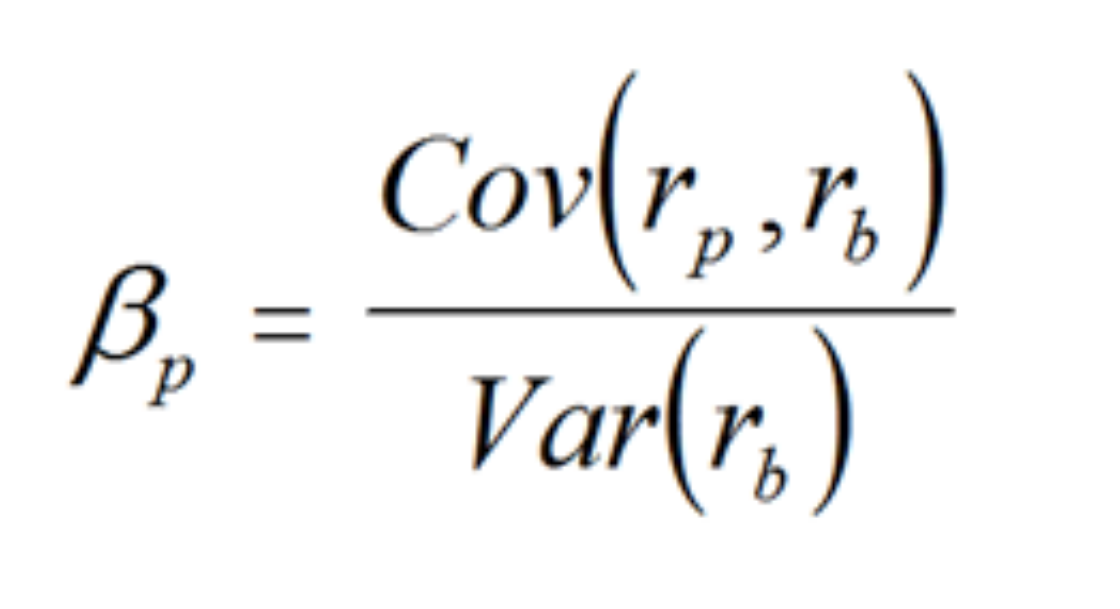

**Onde:**
1. r(b) = retorno do benchmark
2. r(p) = retorno do ativo

Com isso, tiramos as seguintes conclusões:

<div>
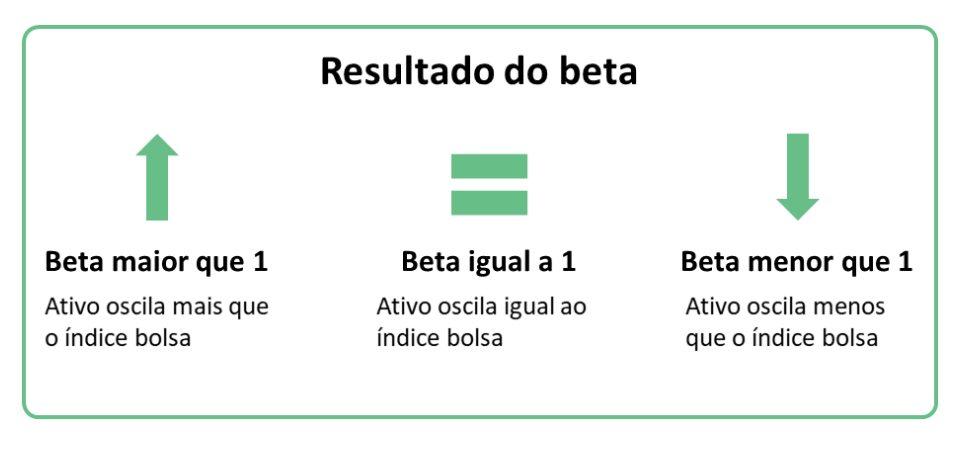

In [71]:
def beta(returns, benchmark):
    """
    Essa função, a partir do fornecimento dos retornos do ativo e do benchmark, calcula o beta do ativo.

    Args:
        returns (pd.Series): série com o retorno do ativo.
        benchmark (pd.Series): série com o retorno do benchmark.

    Returns:
        float: Beta do ativo
    """

    assert returns.shape[0] == benchmark.shape[0], "Séries temporais com dimensões diferentes"

    covariance = returns.cov(benchmark)

    benchmark_vol = np.var(benchmark)

    return covariance / benchmark_vol

In [73]:
#Escolhendo a ação e o benchmark
df = yf.download(["ITUB3.SA"], start='2019-01-01')
returns = tq.metrics.returns(df["Close"])
df_benchmark = yf.download(['^BVSP'], start='2019-01-01')
benchmark = tq.metrics.returns(df_benchmark['Close'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [78]:
print("O beta vale:", beta(returns,benchmark))

O beta vale: 0.8370720692786356


Logo, nota-se que beta < 1, logo a ação do Itaú é capaz de oscilar ainda menos do que o Ibovespa no período de 2019 a 2023, ressaltando-se, assim, sua baixa volatilidade